**Microscopic SI model with (global) threshold contagion dynamics**

- $\theta$ - Threshold value.

In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sys
import os

project_root = '/mnt/c/Users/toniv/Documents/Github/Micro_and_Macro_SIRS_Modelling'
src_path = os.path.join(project_root, 'src')
sys.path.append(project_root)
sys.path.append(src_path)

In [3]:
# load the graph and the real data
G = nx.read_gml("../networks/migration_top_comm.gml")
timestamps = pd.read_csv("../data/sliced_user_timestamps.csv", index_col=0)

In [4]:
# slice the timestamps to the users of the Top Community
graph_nodes = set(G.nodes())
timestamps['user'] = timestamps['user'].astype(str)
filtered_timestamps = timestamps[timestamps['user'].isin(graph_nodes)]

# get the real infection evolution
date_counts = filtered_timestamps['day'].value_counts().sort_index()
I_real = date_counts.cumsum()

# get the initial infected: Early-infected + infected at day 0
initial_infected = filtered_timestamps[filtered_timestamps["day"] == 0]["user"].tolist()

# max steps
max_steps = len(I_real) - 1

**One run with arbitrary parameters**

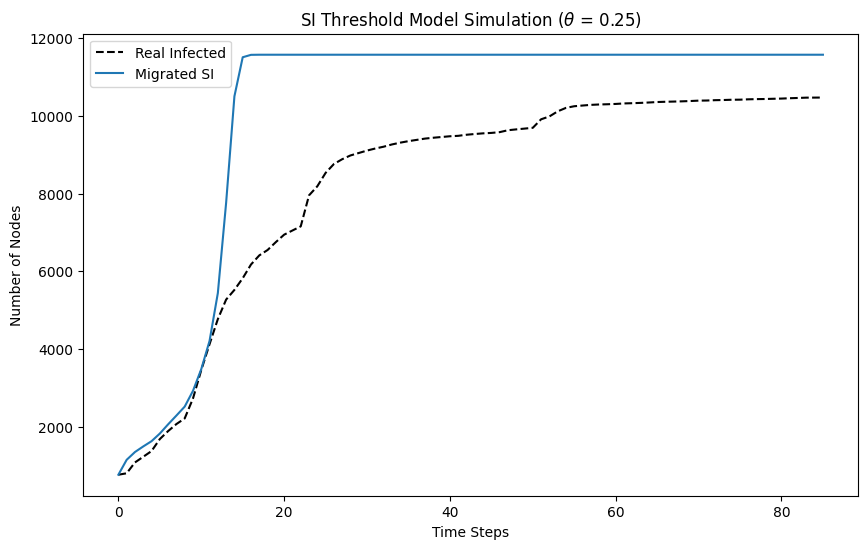

In [6]:
from src.microscopic import si_threshold_model

threshold = 0.25

S, I = si_threshold_model(G, initial_infected, threshold, max_steps)

plt.figure(figsize=(10, 6))
plt.plot(I_real.index, I_real.values, linestyle='--', color='black', label='Real Infected')
#plt.plot(S, label='Susceptible')
plt.plot(I, label='Migrated SI')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title(r'SI Threshold Model Simulation ($\theta$ = '+str(threshold)+')')
plt.legend()
plt.show()

**Fitting the model. Finding the best threshold**

Loss (MSE) at iteration with $\theta = $ [0.25]: 5131382.534883721
Loss (MSE) at iteration with $\theta = $ [0.251]: 4014935.3604651163
Loss (MSE) at iteration with $\theta = $ [0.252]: 4012526.7790697673
Loss (MSE) at iteration with $\theta = $ [0.2525]: 3965281.011627907
Loss (MSE) at iteration with $\theta = $ [0.253]: 3964235.430232558
Loss (MSE) at iteration with $\theta = $ [0.25325]: 3954203.1279069767
Loss (MSE) at iteration with $\theta = $ [0.2535]: 3940265.965116279
Loss (MSE) at iteration with $\theta = $ [0.25375]: 3918902.0581395347
Loss (MSE) at iteration with $\theta = $ [0.254]: 3877564.2325581396
Loss (MSE) at iteration with $\theta = $ [0.25425]: 3861667.2558139535
Loss (MSE) at iteration with $\theta = $ [0.2545]: 3861558.5581395347
Loss (MSE) at iteration with $\theta = $ [0.2546]: 3852762.081395349
Loss (MSE) at iteration with $\theta = $ [0.2547]: 3852762.081395349

   Normal return from subroutine COBYLA

   NFVALS =   13   F = 3.852762E+06    MAXCV = 0.000000E+

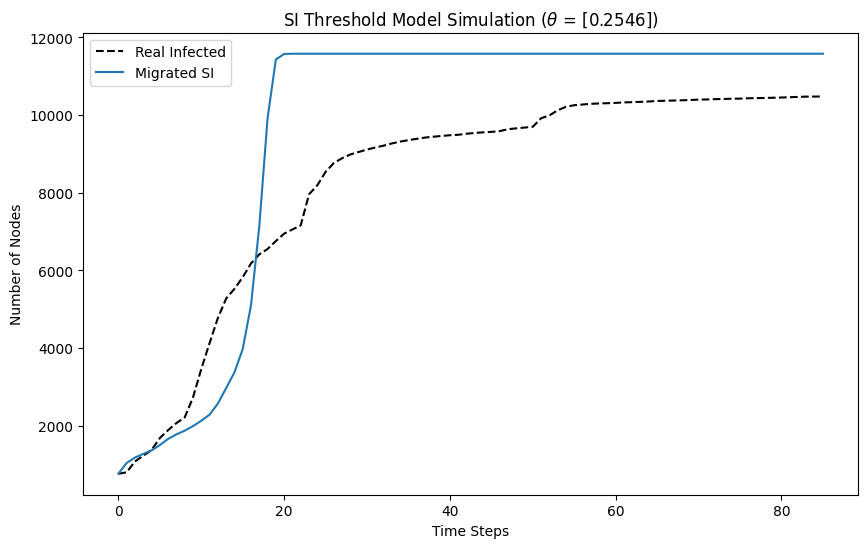

In [8]:
from src.microscopic import si_threshold_model, Threshold_ParamTracker

 # fit the model to our data
initial_params = 0.25
options = {'rhobeg': 0.001, # Initial stepsize
           'disp': True,    # Display convergence messages
           'maxiter': 50
 }

# threshold boundaries checked for running the previous cell
# constraints = [
#     {'type': 'ineq', 'fun': lambda x: x - 0.2},  # x > 0.2
#     {'type': 'ineq', 'fun': lambda x: 0.3 - x}   # x < 0.3
# ]

tracker = Threshold_ParamTracker()

result = minimize(tracker.threshold_loss,
                  initial_params,
                  args=(G, initial_infected, si_threshold_model, I_real),
                  method='COBYLA',
                  # constraints=constraints,
                  options=options)     
S, I = si_threshold_model(G, initial_infected, tracker.best_threshold, max_steps)

plt.figure(figsize=(10, 6))
plt.plot(I_real.index, I_real.values, linestyle='--', color='black', label='Real Infected')
plt.plot(I, label='Migrated SI')
plt.xlabel('Time Steps')
plt.ylabel('Number of Nodes')
plt.title(r'SI Threshold Model Simulation ($\theta$ = '+str(tracker.best_threshold )+')')
plt.legend()
plt.show()